In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import autosklearn.classification
from tpot import TPOTClassifier
import matplotlib.pyplot as plt
from h2o.sklearn import H2OAutoMLClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# Загрузка данных
df = pd.read_csv('/home/xissah/automl_research_dir/datasets/train_set.csv')

# Предобработка данных
cols_to_drop = [col for col in list(df) if df[col].nunique() <= 1]
df = df.drop(columns=cols_to_drop)

X = df.iloc[:, :-1]
y = df["class"]

binary_features = X.columns[X.isin([0, 1]).all()].tolist()
numeric_features_nb = X.select_dtypes("number").columns.drop(binary_features).tolist()

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
mms = MinMaxScaler()

ct = make_column_transformer(
    (enc, ["protocol_type", "service", "flag"]),
    (mms, numeric_features_nb),
    remainder="passthrough",
)

In [3]:
# Настройка кросс-валидации и метрик
scoring = ['accuracy', 'f1_macro']
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [4]:
results = {}

param_grid_gnb = {
    'gaussiannb__var_smoothing': np.logspace(0, -15, num=200)
}

pipeline_gnb = make_pipeline(ct, GaussianNB())
grid_gnb = GridSearchCV(pipeline_gnb, param_grid_gnb, cv=cv, scoring=scoring, refit='accuracy')
grid_gnb.fit(X, y)
cv_results_gnb = cross_validate(grid_gnb.best_estimator_, X, y, cv=cv, scoring=scoring)
results['GaussianNB_accuracy'] = cv_results_gnb['test_accuracy'].mean()
results['GaussianNB_f1'] = cv_results_gnb['test_f1_macro'].mean()
results['GaussianNB_best_params'] = grid_gnb.best_params_
print(f"GaussianNB - Accuracy: {results['GaussianNB_accuracy']}, F1: {results['GaussianNB_f1']}, Best Params: {results['GaussianNB_best_params']}")

GaussianNB - Accuracy: 0.8971367386259612, F1: 0.8968341469570479, Best Params: {'gaussiannb__var_smoothing': 1.217382727739662e-08}


In [6]:
param_grid_lda = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],
}
pipeline_lda = make_pipeline(ct, LinearDiscriminantAnalysis())
grid_lda = GridSearchCV(pipeline_lda, param_grid_lda, cv=cv, scoring=scoring, refit='accuracy', error_score='raise')
grid_lda.fit(X, y)
cv_results_lda = cross_validate(grid_lda.best_estimator_, X, y, cv=cv, scoring=scoring)
results['LinearDiscriminantAnalysis_accuracy'] = cv_results_lda['test_accuracy'].mean()
results['LinearDiscriminantAnalysis_f1'] = cv_results_lda['test_f1_macro'].mean()
results['LinearDiscriminantAnalysis_best_params'] = grid_lda.best_params_
print(f"LinearDiscriminantAnalysis - Accuracy: {results['LinearDiscriminantAnalysis_accuracy']}, F1: {results['LinearDiscriminantAnalysis_f1']}, Best Params: {results['LinearDiscriminantAnalysis_best_params']}")

LinearDiscriminantAnalysis - Accuracy: 0.9538610404282617, F1: 0.9535859582860272, Best Params: {'lineardiscriminantanalysis__solver': 'svd'}


In [5]:
param_grid_lr = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
pipeline_lr = make_pipeline(ct, LogisticRegression(max_iter=9000))
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv, scoring=scoring, refit='accuracy')
grid_lr.fit(X, y)
cv_results_lr = cross_validate(grid_lr.best_estimator_, X, y, cv=cv, scoring=scoring)
results['LogisticRegression_accuracy'] = cv_results_lr['test_accuracy'].mean()
results['LogisticRegression_f1'] = cv_results_lr['test_f1_macro'].mean()
results['LogisticRegression_best_params'] = grid_lr.best_params_
print(f"LogisticRegression - Accuracy: {results['LogisticRegression_accuracy']}, F1: {results['LogisticRegression_f1']}, Best Params: {results['LogisticRegression_best_params']}")

LogisticRegression - Accuracy: 0.9555282400557379, F1: 0.9552570305505235, Best Params: {'logisticregression__C': 0.1}


In [8]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
}
pipeline_rf = make_pipeline(ct, RandomForestClassifier())
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv, scoring=scoring, refit='accuracy')
grid_rf.fit(X, y)
cv_results_rf = cross_validate(grid_rf.best_estimator_, X, y, cv=cv, scoring=scoring)
results['RandomForestClassifier_accuracy'] = cv_results_rf['test_accuracy'].mean()
results['RandomForestClassifier_f1'] = cv_results_rf['test_f1_macro'].mean()
results['RandomForestClassifier_best_params'] = grid_rf.best_params_
print(f"RandomForestClassifier - Accuracy: {results['RandomForestClassifier_accuracy']}, F1: {results['RandomForestClassifier_f1']}, Best Params: {results['RandomForestClassifier_best_params']}")

RandomForestClassifier - Accuracy: 0.9971286818446656, F1: 0.9971147330291199, Best Params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}


In [9]:
param_grid_ada = {
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 1.0, 10]
}
pipeline_ada = make_pipeline(ct, AdaBoostClassifier())
grid_ada = GridSearchCV(pipeline_ada, param_grid_ada, cv=cv, scoring=scoring, refit='accuracy')
grid_ada.fit(X, y)
cv_results_ada = cross_validate(grid_ada.best_estimator_, X, y, cv=cv, scoring=scoring)
results['AdaBoostClassifier_accuracy'] = cv_results_ada['test_accuracy'].mean()
results['AdaBoostClassifier_f1'] = cv_results_ada['test_f1_macro'].mean()
results['AdaBoostClassifier_best_params'] = grid_ada.best_params_
print(f"AdaBoostClassifier - Accuracy: {results['AdaBoostClassifier_accuracy']}, F1: {results['AdaBoostClassifier_f1']}, Best Params: {results['AdaBoostClassifier_best_params']}")

AdaBoostClassifier - Accuracy: 0.9903539897073306, F1: 0.9903063392830421, Best Params: {'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 200}


In [10]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

# Запуск H2O
h2o.init()

# Создание обертки для H2OAutoML
class H2OAutoMLClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_runtime_secs=60, seed=42):
        self.max_runtime_secs = max_runtime_secs
        self.seed = seed
        self.automl = None
        self.classes_ = None

    def fit(self, X, y):
        # Преобразование данных в H2OFrame
        train = h2o.H2OFrame(pd.concat([X, y], axis=1))
        predictors = X.columns.tolist()
        response = y.name

        # Запуск H2OAutoML
        self.automl = H2OAutoML(max_runtime_secs=self.max_runtime_secs, seed=self.seed)
        self.automl.train(x=predictors, y=response, training_frame=train)
        
        # Установка атрибута classes_
        self.classes_ = y.unique().tolist()
        return self

    def predict(self, X):
        # Преобразование данных в H2OFrame
        test = h2o.H2OFrame(X)
        predictions = self.automl.predict(test).as_data_frame()
        return predictions['predict'].values

# Создание экземпляра H2OAutoML
h2o_automl_wrapper = H2OAutoMLClassifier(max_runtime_secs=180, seed=42)

# Кросс-валидация
cv_results_h2o = cross_validate(h2o_automl_wrapper, X, y, cv=cv, scoring=scoring)

results['H2OAutoMLClassifier_accuracy'] = cv_results_h2o['test_accuracy'].mean()
results['H2OAutoMLClassifier_f1'] = cv_results_h2o['test_f1_macro'].mean()

print(f"Средняя точность: {cv_results_h2o['test_accuracy'].mean()}")
print(f"Средний F1-макро: {cv_results_h2o['test_f1_macro'].mean()}")

# Остановка H2O
h2o.shutdown()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.9" 2023-10-17; OpenJDK Runtime Environment (build 17.0.9+9-Ubuntu-122.04); OpenJDK 64-Bit Server VM (build 17.0.9+9-Ubuntu-122.04, mixed mode, sharing)
  Starting server from /home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2q828orc
  JVM stdout: /tmp/tmp2q828orc/h2o_xissah_started_from_python.out
  JVM stderr: /tmp/tmp2q828orc/h2o_xissah_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,3 months
H2O_cluster_name:,H2O_from_python_xissah_napb7v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,956 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'service' has levels not trained on: ["http_8001"]
  warnings.warn(w)
/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
06:30:30.868: _train param, Dropping bad and constant columns: [urgent]

██████
06:30:48.216: _train param, Dropping bad and constant columns: [urgent]

██
06:30:53.801: _train param, Dropping bad and constant columns: [urgent]

███████████████
06:31:34.980: _train param, Dropping unused columns: [urgent]


06:31:36.241: _train param, Dropping bad and constant columns: [urgent]

████
06:31:47.678: _train param, Dropping bad and constant columns: [urgent]

███
06:31:56.452: _train param, Dropping bad and constant columns: [urgent]

█████
06:32:10.583: _train param, Dropping bad and constant columns: [urgent]

████
06:32:24.5: _train param, Dropping bad and constant columns: [urgent]

██████
06:32:41.57: _train param, Dropping unused columns: [urgent]

█
06:32:42.16: _train param, Dropping unused columns: [urgent]


06:32:43.718: _train param, Dropping bad and constant column

/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
06:39:39.351: _train param, Dropping bad and constant columns: [urgent]

█████████
06:40:03.890: _train param, Dropping bad and constant columns: [urgent]

██
06:40:09.829: _train param, Dropping bad and constant columns: [urgent]

████████████████████
06:41:06.788: _train param, Dropping unused columns: [urgent]


06:41:08.146: _train param, Dropping bad and constant columns: [urgent]

████
06:41:19.108: _train param, Dropping bad and constant columns: [urgent]

███
06:41:27.245: _train param, Dropping bad and constant columns: [urgent]

████
06:41:38.980: _train param, Dropping bad and constant columns: [urgent]

████
06:41:52.71: _train param, Dropping bad and constant columns: [urgent]

█████
06:42:06.352: _train param, Dropping unused columns: [urgent]


06:42:07.302: _train param, Dropping unused columns: [urgent]

█
06:42:08.894: _train param, Dropping bad and consta

/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'service' has levels not trained on: ["http_8001"]
  warnings.warn(w)
/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
06:45:45.949: _train param, Dropping bad and constant columns: [land]

███████
06:46:03.871: _train param, Dropping bad and constant columns: [land]

██
06:46:09.997: _train param, Dropping bad and constant columns: [land]

██████████████
06:46:50.461: _train param, Dropping unused columns: [land]


06:46:51.824: _train param, Dropping bad and constant columns: [land]

█████
06:47:06.181: _train param, Dropping bad and constant columns: [land]

███
06:47:14.549: _train param, Dropping bad and constant columns: [land]

█████
06:47:28.383: _train param, Dropping bad and constant columns: [land]

█████
06:47:44.664: _train param, Dropping bad and constant columns: [land]

██████
06:48:00.47: _train param, Dropping unused columns: [land]


06:48:01.353: _train param, Dropping unused columns: [land]

█
06:48:02.995: _train param, Dropping bad and constant columns: [land]

██
06:

/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'service' has levels not trained on: ["http_8001"]
  warnings.warn(w)
/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
06:57:55.822: _train param, Dropping bad and constant columns: [urgent]

███████
06:58:15.634: _train param, Dropping bad and constant columns: [urgent]

██
06:58:21.181: _train param, Dropping bad and constant columns: [urgent]

█████████████
06:58:59.604: _train param, Dropping unused columns: [urgent]

█
06:59:00.973: _train param, Dropping bad and constant columns: [urgent]

████
06:59:13.414: _train param, Dropping bad and constant columns: [urgent]

███
06:59:21.573: _train param, Dropping bad and constant columns: [urgent]

█████
06:59:35.817: _train param, Dropping bad and constant columns: [urgent]

█████
06:59:50.798: _train param, Dropping bad and constant columns: [urgent]

██████
07:00:07.167: _train param, Dropping unused columns: [urgent]


07:00:08.449: _train param, Dropping unused columns: [urgent]

█
07:00:10.226: _train param, Dropping bad and constant c

/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Средняя точность: 0.9976712067994823
Средний F1-макро: 0.9976601904637391
H2O session _sid_911b closed.


/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/tmp/ipykernel_3755/1107057021.py:52: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [11]:
# AutoSklearnClassifier
autosk = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=180)
cv_results_autosk = cross_validate(autosk, X, y, cv=cv, scoring=scoring)
results['AutoSklearnClassifier_accuracy'] = cv_results_autosk['test_accuracy'].mean()
results['AutoSklearnClassifier_f1'] = cv_results_autosk['test_f1_macro'].mean()
print(f"Средняя точность: {cv_results_autosk['test_accuracy'].mean()}")
print(f"Средний F1-макро: {cv_results_autosk['test_f1_macro'].mean()}")

/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column protocol_type has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column service has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column flag has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/home/xissah/automl_research_dir/automl_research_env/lib/python3.9/site-packages/a

Средняя точность: 0.9970493141454837
Средний F1-макро: 0.9970350001698287


In [12]:
# TPOTClassifier

ct_tpot = make_column_transformer(
    (enc, ["protocol_type", "service", "flag"]),
    remainder="passthrough"
)

tpot_pipe = make_pipeline(ct_tpot, TPOTClassifier(max_time_mins=3))
cv_results_tpot = cross_validate(tpot_pipe, X, y, cv=cv, scoring=scoring)
results['TPOTClassifier_accuracy'] = cv_results_tpot['test_accuracy'].mean()
results['TPOTClassifier_f1'] = cv_results_tpot['test_f1_macro'].mean()
print(f"Средняя точность: {cv_results_tpot['test_accuracy'].mean()}")
print(f"Средний F1-макро: {cv_results_tpot['test_f1_macro'].mean()}")

Средняя точность: 0.9972742291218871
Средний F1-макро: 0.9972610245383877


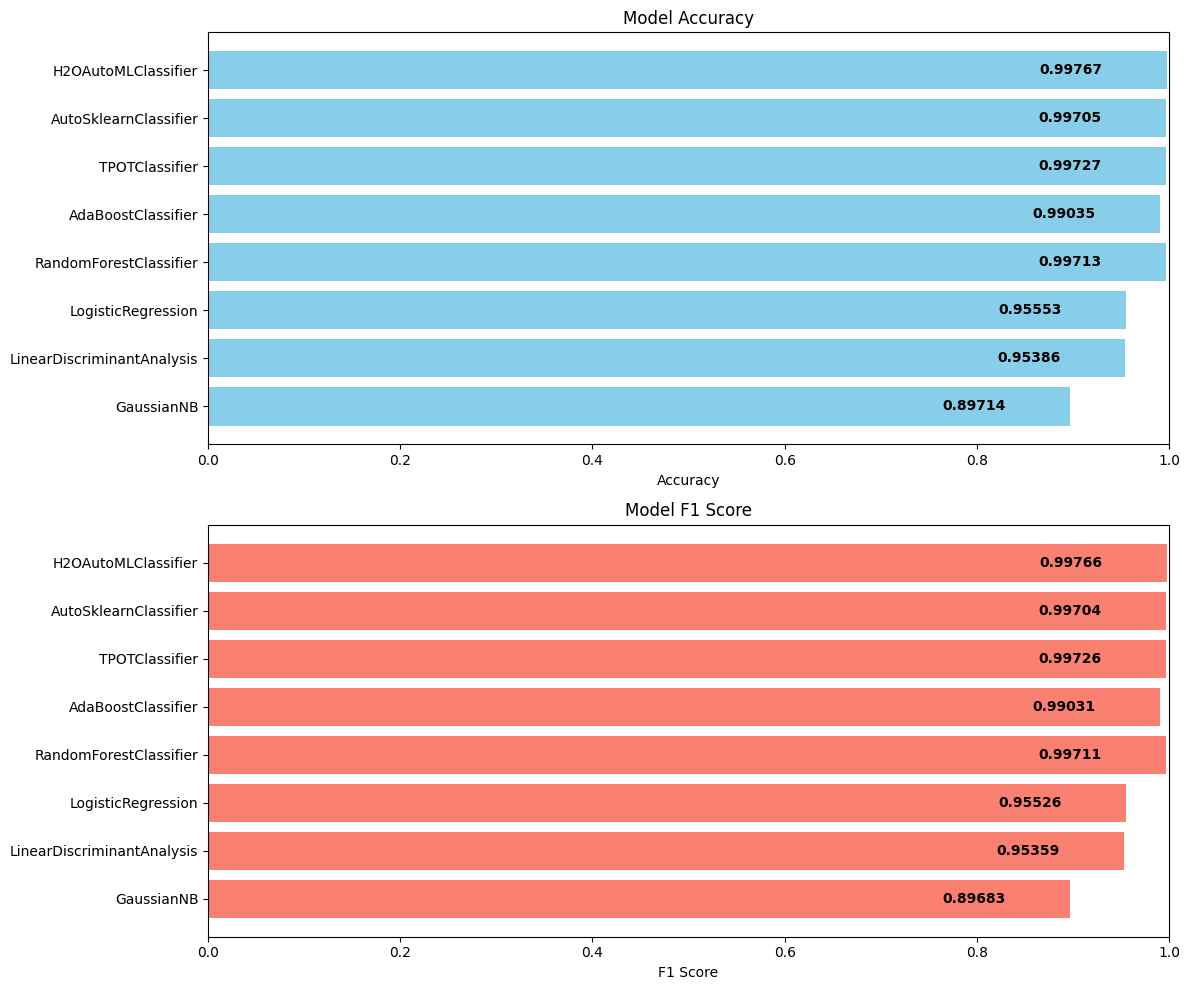

In [4]:
import matplotlib.pyplot as plt

# Данные моделей
model_names = [
    'GaussianNB', 'LinearDiscriminantAnalysis', 'LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier',
               'TPOTClassifier', 'AutoSklearnClassifier', 'H2OAutoMLClassifier'
               ]
accuracies = [results[f'{model}_accuracy'] for model in model_names]
f1_scores = [results[f'{model}_f1'] for model in model_names]

# Построение диаграмм
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Диаграмма точности (accuracy)
ax[0].barh(model_names, accuracies, color='skyblue')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_xlim(0, 1)

# Добавление подписей к столбикам точности
for i, v in enumerate(accuracies):
    ax[0].text(v - 0.1, i, f'{v:.5f}', color='black', va='center', ha='center', fontweight='bold')

# Диаграмма F1 (f1_score)
ax[1].barh(model_names, f1_scores, color='salmon')
ax[1].set_title('Model F1 Score')
ax[1].set_xlabel('F1 Score')
ax[1].set_xlim(0, 1)

# Добавление подписей к столбикам F1
for i, v in enumerate(f1_scores):
    ax[1].text(v - 0.1, i, f'{v:.5f}', color='black', va='center', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [18]:
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [2]:
import pickle
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)